In [1]:
import xcast as xc 
import xarray as xr 
import cartopy.crs as ccrs 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
model1 = xr.open_dataset('gefs_week1_hind.nc')
obs1 = xr.open_dataset('obs_week1_hind.nc')
fmodel1 = xr.open_dataset('gefs_week1_fcst.nc')
model = model1.precip.expand_dims({'M':[0]})
fmodel = fmodel1.precip.expand_dims({'M':[0]})
obs = obs1.precip.expand_dims({'M':[0]})

In [3]:
obs, model = xc.match(obs, model)

In [4]:
mask_missing = model.mean('time', skipna=False).mean('M', skipna=False)
mask_missing = xr.ones_like(mask_missing).where(~np.isnan(mask_missing), other=np.nan )
model = model * mask_missing

In [5]:
model = model.sel(lon=slice(-20, 55), lat=slice(-40,40))
fmodel = fmodel.sel(lon=slice(-20, 55), lat=slice(-40,40))
obs = obs.sel(lon=slice(-20, 55), lat=slice(-40,40))
model = xc.regrid(model, obs.lon, obs.lat)
fmodel = xc.regrid(fmodel, obs.lon, obs.lat)

In [6]:
epoelm_kwargs = {
            'regularization': -10,
            'hidden_layer_size': 5,
            'activation': 'relu',# 'sigm', 'tanh', 'lin', 'leaky', 'relu', 'softplus'],
            'preprocessing':'minmax',#minmax', 'std', 'none' ],
            'n_estimators': 30,
}

In [7]:
hindcasts_prob = []
i=1
for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=5):
    print("window {}".format(i))
    i += 1
    epoelm = xc.EPOELM(**epoelm_kwargs)
    epoelm.fit(xtrain, ytrain)
    probs =  epoelm.predict_proba(xtest)
    hindcasts_prob.append(probs.isel(time=2))
hindcasts_prob = xr.concat(hindcasts_prob, 'time')

window 1
window 2
window 3
window 4
window 5
window 6
window 7
window 8
window 9
window 10
window 11
window 12
window 13
window 14
window 15
window 16
window 17
window 18
window 19
window 20
window 21
window 22
window 23
window 24
window 25
window 26
window 27
window 28
window 29
window 30
window 31
window 32
window 33
window 34
window 35
window 36
window 37
window 38
window 39
window 40
window 41
window 42
window 43
window 44
window 45
window 46
window 47
window 48
window 49
window 50
window 51
window 52
window 53
window 54
window 55
window 56
window 57
window 58
window 59
window 60


In [8]:
hindcasts_prob = xc.gaussian_smooth(hindcasts_prob, kernel=9)
obs = xc.gaussian_smooth(obs, kernel=9)

In [9]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs)
T = ohc.transform(obs)
clim = xr.ones_like(T) * 0.333

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample']


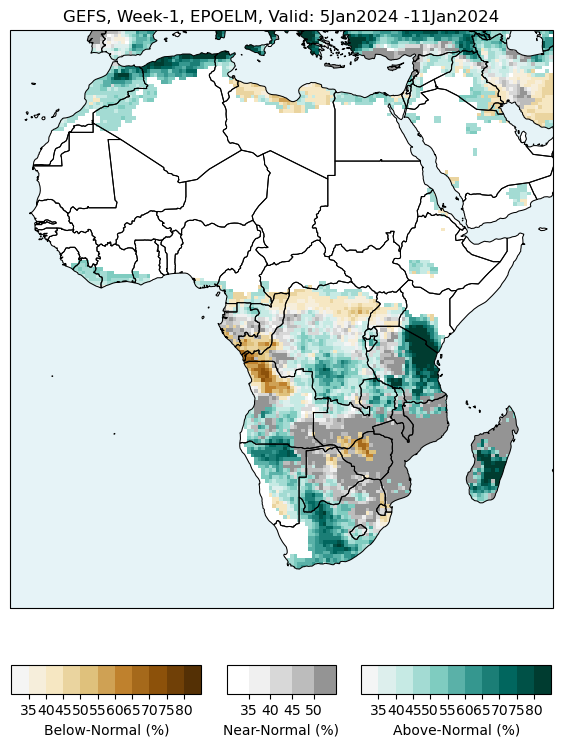

In [10]:
from mprob import mview_probabilistic
fprobs =  epoelm.predict_proba(fmodel)
mview_probabilistic(fprobs.isel(time=0), title='GEFS, Week-1, EPOELM, Valid: 5Jan2024 -11Jan2024', savefig='./gefs_week_1_epoelm.png')

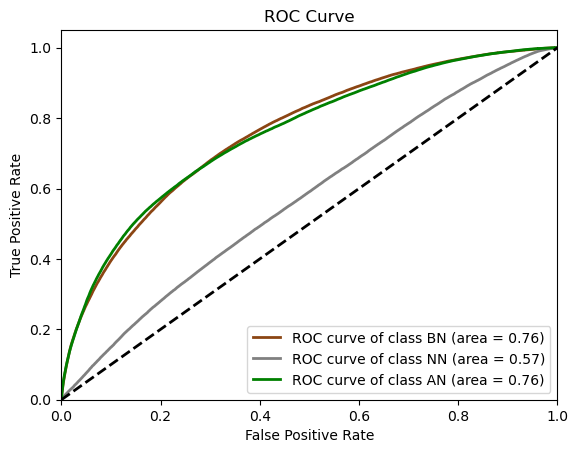

In [11]:
from rocc import view_mroc
ds = hindcasts_prob.assign_coords(M=(['BN', 'NN', 'AN']))
view_mroc(ds, T, savefig='./gefs_week_1_epoelm_roc.png')

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


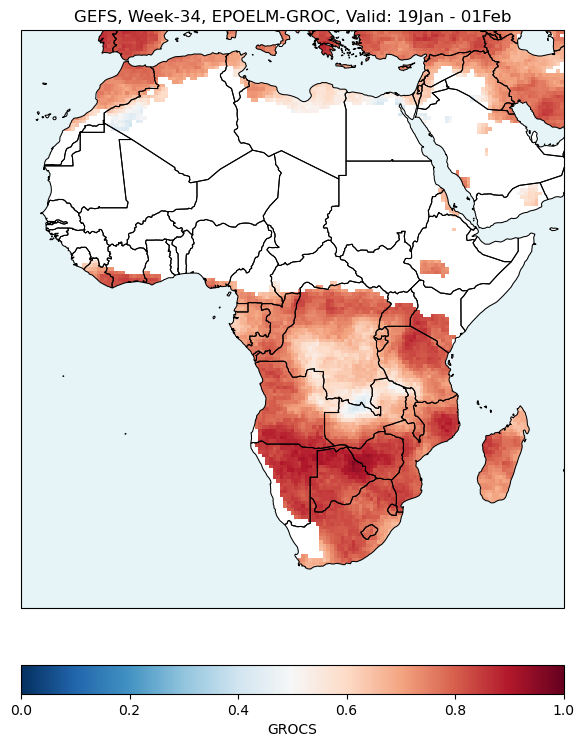

In [12]:
groc = xc.GROCS(hindcasts_prob, T)
from pview import view
view(groc, title='GEFS, Week-34, EPOELM-GROC, Valid: 19Jan - 01Feb', savefig='./gefs_week_1_epoelm_groc.png')

UNABLE TO FIND NAMES FOR FOLLOWING DIMS: ['sample', 'feature']


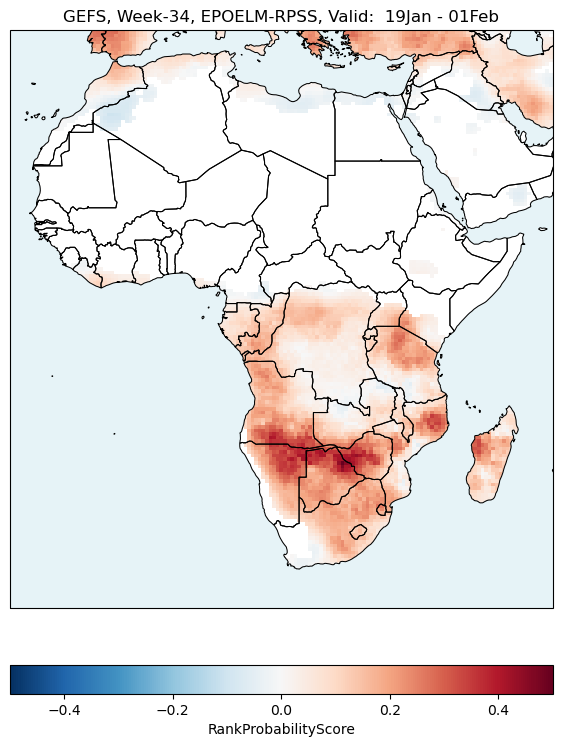

In [13]:
from rpssview import view
clim_rps = xc.RankProbabilityScore(clim, T)
pred_rps = xc.RankProbabilityScore(hindcasts_prob, T)
rpss = 1 - pred_rps / clim_rps
view(rpss, title='GEFS, Week-34, EPOELM-RPSS, Valid:  19Jan - 01Feb', savefig='./gefs_week_1_epoelm_rpss.png')

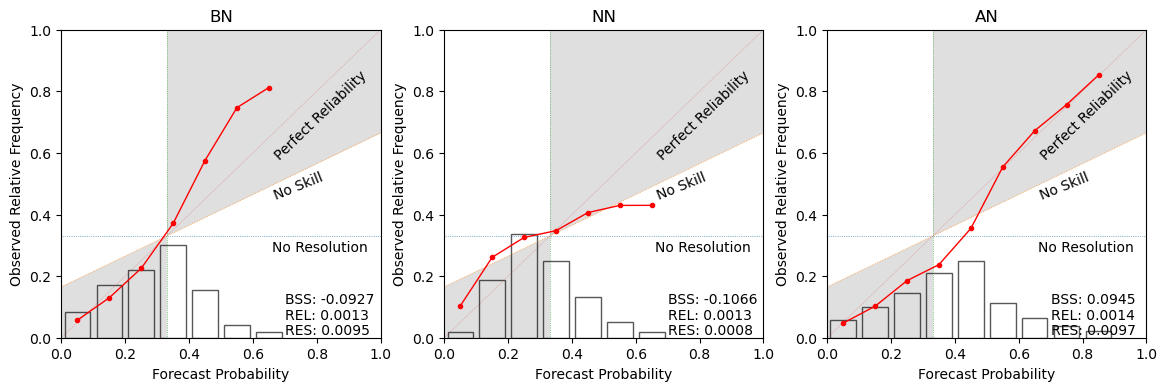

In [14]:
xc.view_reliability(hindcasts_prob, T)
plt.savefig('./gefs_week_1_epoelm_relib.png', dpi=100)